In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
import operator
import pandas.io.data
import re
from dateutil import parser

/home/andre/anaconda3/lib/python3.5/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
def performRFClass(X_train, y_train, X_test, y_test, fout, savemodel=False):
    """
    Random Forest Binary Classification
    """
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    if savemodel == True:
        fname_out = '{}-{}.pickle'.format(fout, datetime.now())
        with open(fname_out, 'wb') as f:
            cPickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    
    return accuracy

In [3]:
def prepareDataForClassification(dataset, start_test):
    """
    generates categorical to be predicted column, attach to dataframe 
    and label the categories
    """
    le = preprocessing.LabelEncoder()
    
    dataset['UpDown'] = dataset['target_variable_dup']
    #dataset.UpDown[dataset.UpDown == 1] = 'Up'
    #dataset.UpDown[dataset.UpDown == 1] = 'Down'
    dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown) #create classes for randomForest
    
    features = dataset.columns[1:-2] # first is index last two are target variable. IGNORE THEM
    X = dataset[features]    
    y = dataset.UpDown    
    
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]    
    
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
    
    return X_train, y_train, X_test, y_test   

In [4]:
def performTimeSeriesCV(X_train, y_train, number_folds):
    """
    Given X_train and y_train (the test set is excluded from the Cross Validation),
    number of folds, the ML algorithm to implement and the parameters to test,
    the function acts based on the following logic: it splits X_train and y_train in a
    number of folds equal to number_folds. Then train on one fold and tests accuracy
    on the consecutive as follows:
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    ....
    Returns mean of test accuracies.
    """
 
    print('Size train set: ', X_train.shape)
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: ', k)
    
    # initialize to zero the accuracies array. It is important to stress that
    # in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    accuracies = np.zeros(number_folds-1)
 
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        
        # the split is the percentage at which to split the folds into train
        # and test. For example when i = 2 we are taking the first 2 folds out 
        # of the total available. In this specific case we have to split the
        # two of them in half (train on the first, test on the second), 
        # so split = 1/2 = 0.5 = 50%. When i = 3 we are taking the first 3 folds 
        # out of the total available, meaning that we have to split the three of them
        # in two at split = 2/3 = 0.66 = 66% (train on the first 2 and test on the
        # following)
        split = float(i-1)/i
        
        # example with i = 4 (first 4 folds):
        #      Splitting the first       4        chunks at          3      /        4
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i))
        
        # as we loop over the folds X and y are updated and increase in size.
        # This is the data that is going to be split and it increases in size 
        # in the loop as we account for more folds. If k = 300, with i starting from 2
        # the result is the following in the loop
        # i = 2
        # X = X_train[:(600)]
        # y = y_train[:(600)]
        #
        # i = 3
        # X = X_train[:(900)]
        # y = y_train[:(900)]
        # .... 
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: ', X.shape) # the size of the dataframe is going to be k*i
 
        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):(index + 4)]
        y_testFold = y[(index + 1):(index + 4)]
        print('size of samples to test ', len(y_testFold))
        print('first index of tested sample ', index+1)        
        
        # i starts from 2 so the zeroth element in accuracies array is i-2. performClassification() is a function which takes care of a classification problem. This is only an example and you can replace this function with whatever ML approach you need.
        accuracies[i-2] = performRFClass(X_trainFolds, y_trainFolds, X_testFold, y_testFold, ' ')
        
        # example with i = 4:
        #      Accuracy on fold         4     :    0.85423
        print('Accuracy on fold ' + str(i) + ': ', accuracies[i-2])
    
    # the function returns the mean of the accuracy on the n-1 folds    
    return accuracies

In [5]:
def performCV_shift(X_train, y_train, windown):
    
    print('Size train set: ', X_train.shape)
    print('samples in each window: ', windown)
    nshifts = len(y_train)-windown+1 # possible shifts N-windown+1    
    ntest = 2  # number of samples to estimate
    accuracies = np.zeros(nshifts-ntest)  
    for i in range(nshifts - ntest): # shift, classify and estimate/test
        # index of the first sample in the window
        print('')        
        # train using the window samples
        X_trainFolds = X_train.loc[i:i+windown, :]
        y_trainFolds = y_train.loc[i:i+windown]
        # test using the samples just after the window (ONE SAMPLE?)        
        X_testFold = X_train.loc[i+windown+1:i+windown+ntest, :]
        y_testFold = y_train.loc[i+windown+1:i+windown+ntest]
        print('size of samples to test ', len(y_testFold))
        print('first index of tested sample ', i+windown+1)                
        accuracies[i] = performRFClass(X_trainFolds, y_trainFolds, X_testFold, y_testFold, ' ')
        print('Accuracy on fold ' + str(i) + ': ', accuracies[i])
    return accuracies

In [6]:
df = pd.read_pickle('data_for_classification.pandas')

In [7]:
df.tail(3)

,GBP/USD,rsi_5 EUR/USD,rsi_20 EUR/USD,ema_5 GBP/USD,ema_10 GBP/USD,ema_15 GBP/USD,macd GBP/USD,rsi_20 GBP/USD,rsi_30 GBP/USD,rsi_5 USD/CHF,...,dema_5 USD/CAD,dema_10 USD/CAD,dema_15 USD/CAD,macd USD/CAD,rsi_5 USD/CAD,rsi_20 USD/CAD,rsi_30 USD/CAD,EUR/USD+GBP/USD,GBP/USD+USD/CHF,target_variable_dup
716,0.185819,0.326138,0.134696,0.171324,0.138457,0.108637,0.352546,0.186431,0.161005,-0.359918,...,-0.208334,-0.316155,-0.373560,-0.557540,-0.433235,-0.407823,-0.386365,0.300285,0.139271,0.0
717,0.179040,-0.141326,0.035372,0.175561,0.148584,0.120486,0.354653,0.169876,0.150131,-0.191552,...,-0.074278,-0.206892,-0.281421,-0.561427,-0.170519,-0.338025,-0.338026,0.278063,0.150141,1.0
718,0.240056,-0.187585,0.019953,0.199214,0.168805,0.139423,0.378946,0.233577,0.200010,-0.241096,...,-0.052117,-0.171405,-0.248173,-0.558505,-0.170519,-0.338025,-0.338026,0.325285,0.204489,1.0


In [13]:
X_train, y_train, X_test, y_test = prepareDataForClassification(df, 200)

In [14]:
accuracies = performCV_shift(X_train, y_train, 65)

Size train set:  (200, 20)
samples in each window:  65

size of samples to test  2
first index of tested sample  66
Accuracy on fold 0:  1.0

size of samples to test  2
first index of tested sample  67
Accuracy on fold 1:  1.0

size of samples to test  2
first index of tested sample  68
Accuracy on fold 2:  1.0

size of samples to test  2
first index of tested sample  69
Accuracy on fold 3:  1.0

size of samples to test  2
first index of tested sample  70
Accuracy on fold 4:  1.0

size of samples to test  2
first index of tested sample  71
Accuracy on fold 5:  1.0

size of samples to test  2
first index of tested sample  72
Accuracy on fold 6:  1.0

size of samples to test  2
first index of tested sample  73
Accuracy on fold 7:  0.5

size of samples to test  2
first index of tested sample  74
Accuracy on fold 8:  0.0

size of samples to test  2
first index of tested sample  75
Accuracy on fold 9:  0.5

size of samples to test  2
first index of tested sample  76
Accuracy on fold 10:  1.

In [15]:
np.size(accuracies)

134

In [16]:
from matplotlib import pyplot
%matplotlib inline

In [17]:
np.mean(accuracies)

0.65298507462686572

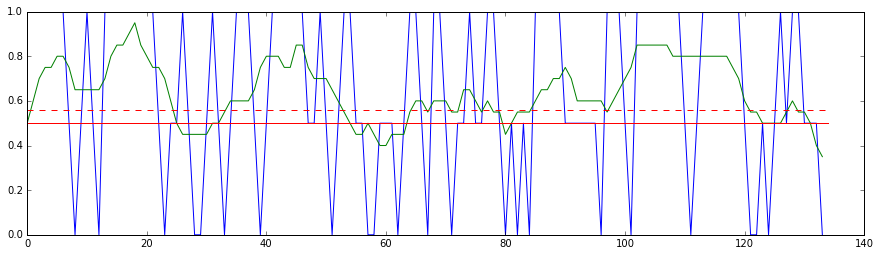

In [18]:
pyplot.figure(figsize=(15,4))
pyplot.plot(accuracies)
pyplot.plot(np.convolve(accuracies, np.ones(10)/10., mode='same')) # average 5 minutes
pyplot.plot([0, len(accuracies)], [0.5, 0.5], 'r-')
pyplot.plot([0, len(accuracies)], [0.56, 0.56], 'r--')

Size train set:  (200, 20)
Size of each fold:  2

Splitting the first 2 chunks at 1/2
Size of train + test:  (4, 20)
size of samples to test  1
first index of tested sample  3
Accuracy on fold 2:  0.0

Splitting the first 3 chunks at 2/3
Size of train + test:  (6, 20)
size of samples to test  1
first index of tested sample  5
Accuracy on fold 3:  0.0

Splitting the first 4 chunks at 3/4
Size of train + test:  (8, 20)
size of samples to test  1
first index of tested sample  7
Accuracy on fold 4:  0.0

Splitting the first 5 chunks at 4/5
Size of train + test:  (10, 20)
size of samples to test  1
first index of tested sample  9
Accuracy on fold 5:  0.0

Splitting the first 6 chunks at 5/6
Size of train + test:  (12, 20)
size of samples to test  1
first index of tested sample  11
Accuracy on fold 6:  0.0

Splitting the first 7 chunks at 6/7
Size of train + test:  (14, 20)
size of samples to test  1
first index of tested sample  13
Accuracy on fold 7:  1.0

Splitting the first 8 chunks at 7

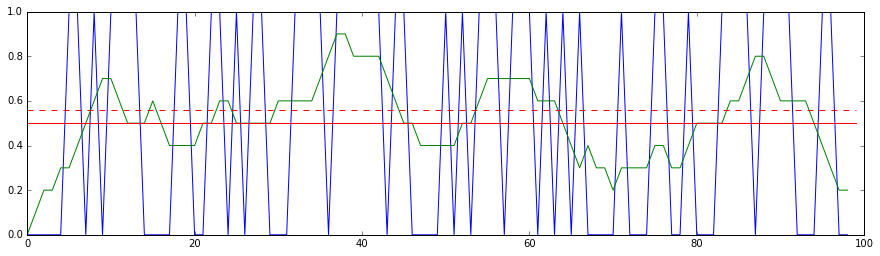

In [10]:
### Using everything bellow or above 5% ###
### And increasing window size ###
accuracies = performTimeSeriesCV(X_train, y_train, 100)
pyplot.figure(figsize=(15,4))
pyplot.plot(accuracies)
pyplot.plot(np.convolve(accuracies, np.ones(10)/10., mode='same')) # average 5 minutes 10 samples
pyplot.plot([0, len(accuracies)], [0.5, 0.5], 'r-')
pyplot.plot([0, len(accuracies)], [0.56, 0.56], 'r--')

In [12]:
print(np.mean(accuracies))

0.515151515152


Lembrando cada amostra é 30s. 
Predizendo até 3 amostras depois, 1:30 s depois.

Conclusões so far:

1. pelo menos 70 amostras para treinar o modelo p/ funcionar > 60%

    equivale à 70*30 = 35 minutos amostras anterior